# Image Prediction:
1. Load the model with latest saved weights and obtain prediction results.
2. Print the generated damage mask, damaged image, predicted image and ground truth

In [1]:
from copy import deepcopy
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import gc
import datetime
import tensorflow as tf
from utils.generateMask3 import generateMasks

from networks.pconv_model import PConvUnet
from utils.pconv_utils import random_mask

%load_ext autoreload
%autoreload 2

# SETTINGS
SAMPLE_IMAGE = 'data/temp/18_good.jpg'
SAMPLE_IMAGE_BAD = 'data/temp_bad/18.jpg'

BATCH_SIZE = 4

Using TensorFlow backend.


(256, 256, 3)


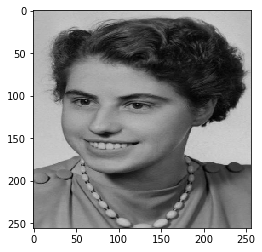

In [2]:
sample_img = cv2.imread(SAMPLE_IMAGE)
sample_img = cv2.resize(sample_img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
plt.imshow(sample_img)
print(str(sample_img.shape))


# Model Loading
We'll load the model trained on ImageNet

In [5]:
model = PConvUnet(weight_filepath='data/logs/')
model.load('data/logs/173_weights_2018-12-16-14-43-57.h5')

In [6]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, folder, *args, **kwargs):
        generator = super().flow_from_directory(directory, classes = [folder], class_mode=None, *args, **kwargs)
        while True:
            # Get augmentend image samples
            ori = next(generator)
            print("ori "+ str(ori.shape[0]))
            #plt.imshow(ori[0])

            # Get masks for each image sample
            m1 = generateMasks(SAMPLE_IMAGE_BAD)
            plt.imshow(m1*255)
            mask = np.stack([m1 for i in range(ori.shape[0])], axis=0)
            
            #print("mask1 max "+ str(mask1.max()))
            #plt.imshow(mask1*255)


            # Apply masks to all image sample
            masked = deepcopy(ori)
            print("masked shape "+ str(masked.shape))
            print("mask shape "+ str(mask.shape))
            masked[mask==0] = 1
            cv2.imwrite('data/mask/masked_1.jpg', masked[0])

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori


0it [00:00, ?it/s]

Found 1 images belonging to 1 classes.
ori 1
max value 252
mask.shape (720, 480)
mask_4.max 252
masked shape (1, 256, 256, 3)
mask shape (1, 256, 256, 3)


NameError: name 'NullFormatter' is not defined

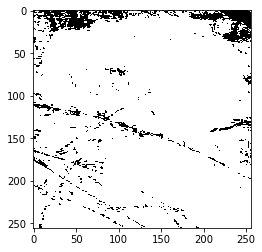

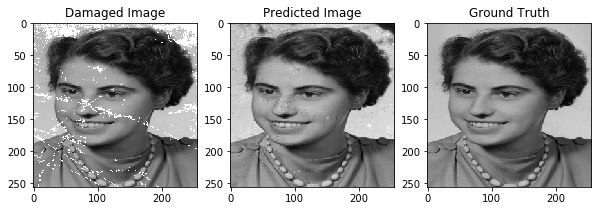

In [7]:
NEW_TEST = "temp"
new_datagen = DataGenerator(rescale=1./255)
new_generator = new_datagen.flow_from_directory(
    "data",NEW_TEST, target_size=(256, 256), batch_size=BATCH_SIZE, seed=1
)

n = 0
for (masked, mask), ori in tqdm(new_generator):
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(sample_img)
        axes[0].set_title('Damaged Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Ground Truth')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
        axes[2].xaxis.set_major_formatter(NullFormatter())
        axes[2].yaxis.set_major_formatter(NullFormatter())
        #plt.axis[1]('off')
                       
        plt.savefig(r'data/test_images/new_img2_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 10:
        break

Seems to work well. We can try plotting the reconstructed image of the last prediction

(256, 256, 3)
196608


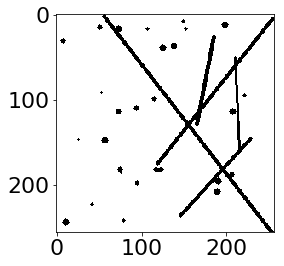

In [58]:
random_mask1 = random_mask(256, 256)
plt.imshow(random_mask1*255)
#cv2.imwrite('data/mask/ramdom_mask.jpg', random_mask1)
#read = cv2.imread('data/mask/ramdom_mask.jpg', cv2.IMREAD_COLOR)
print(str(random_mask1.shape))
print(str(random_mask1.size))

In [ ]:
from os import listdir
path = 'data/logs/initial_training'
loss = []
val = []
count = 0
for f in listdir(path):
    #print("f: "+str(f))
    for e in tf.train.summary_iterator(path+'/'+f):
        for v in e.summary.value:
            if v.tag == 'loss':
                #print("loss: " +str(v.simple_value))
                loss.append(v.simple_value*0.01)
                count = count + 1
            if v.tag == 'val_loss':
                #print("val_loss: " +str(v.simple_value))
                val.append(v.simple_value*0.01)
                # plotting the points  
                
#Plot Validation and training losses
plt.plot(val) 
  
# naming the x axis 
#plt.xlabel('x - axis') 
# naming the y axis 
#plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('Validation Loss')
plt.rcParams.update({'font.size': 22,})
  
# function to show the plot 
plt.show()

plt.plot(loss)
plt.title('Loss')
plt.rcParams.update({'font.size': 22,})
  
# function to show the plot 
plt.show()